### Problem Statement

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive. **We want to predict whether or not a donor will give blood the next time the vehicle comes to campus.**

This competitions uses log loss as its evaluation metric, so the predictions you submit are the probability that a donor made a donation in March 2007. https://www.drivendata.org/competitions/2/warm-up-predict-blood-donations/page/7/



### 1. Getting the Data Set

Original Data Set: 
https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center

DrivenData.org has the data split into train and test: 
https://www.drivendata.org/competitions/2/warm-up-predict-blood-donations/data/

Variables - Four predictors and one outcome

R (Recency - months since last donation) 

F (Frequency - total number of donation) 

M (Monetary - total blood donated in c.c.) 

T (Time - months since first donation)

A variable representing whether the person donated blood in March 2007 (1 stand for donating blood; 0 stands for not donating).

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [197]:
df = pd.read_csv('data/train.csv')

In [200]:
df.head(2)

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1


In [59]:
df.columns=['ID','Recency','Donations','Monetary','Time','Target']

In [60]:
df = df.drop('ID',axis=1) # ID is not needed for trainig the model
df.head(3)

,Recency,Donations,Monetary,Time,Target
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1


In [61]:
# Monetary is just Donations times 250. It's redundant.
df = df.drop('Monetary',axis=1)

### 2. Explore the Data

First simple pair plot of all the variables shows that they are all skewed. We should make probability plots to see how abnormal the data is.

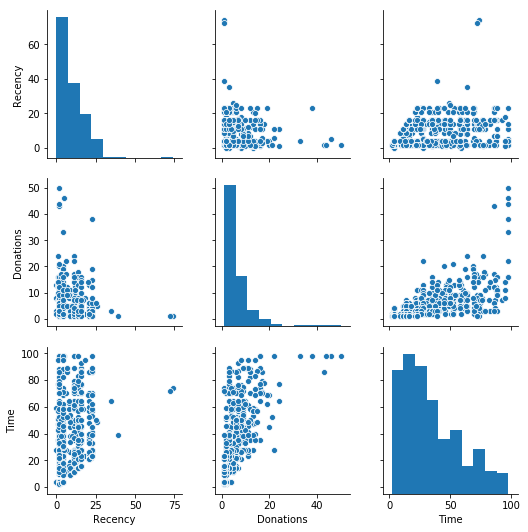

In [62]:
sns.pairplot(df.drop('Target',axis=1))

As we see below, none of the predictors are normally distributed. Thus we may improve our model's predictive power by normalizing.

In [63]:
from scipy.stats import probplot

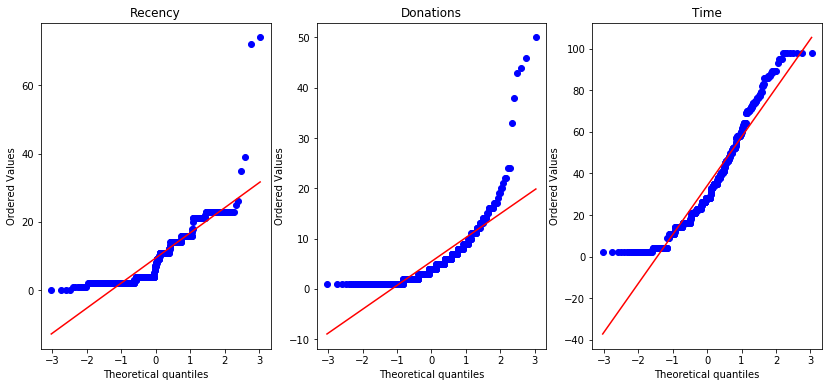

In [82]:
fig = plt.figure(figsize=(14,6))
ax1,ax2,ax3 = (plt.subplot(131),plt.subplot(132),plt.subplot(133))
res = probplot(df.Recency,plot=ax1)
res = probplot(df.Donations,plot=ax2)
res = probplot(df.Time,plot=ax3)
ax1.title.set_text('Recency')
ax2.title.set_text('Donations')
ax3.title.set_text('Time')

Pairplot:

* Monetary is highly correlated with Donations so we will drop Monetary
* Low Recency appears to predict donation
* High Donations is somewhat predictive of donation
* Time does not appear to pick anything on its own

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


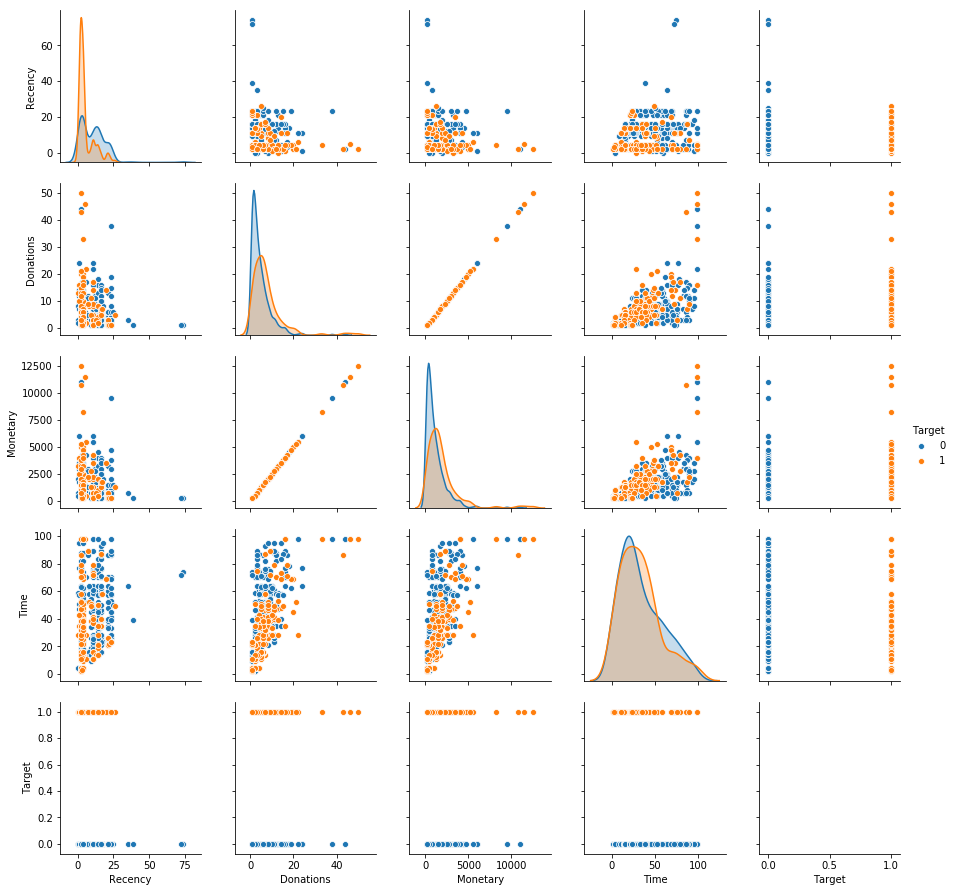

In [6]:
sns.pairplot(df,hue='Target')

Descriptive Stats:

* About 24% of the donors in the set will donate again in March 2007
* March donors average almost 8 donations. Non-March donors average less than 5
* March donors mean recency is about 5-6 months. Non March donors recency is 10-11 months
* There is basically no diffference in the time values for the March donors.

In [8]:
df.describe()

,Recency,Donations,Time,Target
count,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,34.050347,0.239583
std,8.175454,5.740010,24.227672,0.427200
min,0.000000,1.000000,2.000000,0.000000
25%,2.000000,2.000000,16.000000,0.000000
50%,7.000000,4.000000,28.000000,0.000000
75%,14.000000,7.000000,49.250000,0.000000
max,74.000000,50.000000,98.000000,1.000000


In [9]:
df[df.Target==1].describe()

,Recency,Donations,Time,Target
count,138.000000,138.000000,138.000000,138.0
mean,5.637681,7.681159,33.195652,1.0
std,5.513013,7.758194,23.343158,0.0
min,0.000000,1.000000,2.000000,1.0
25%,2.000000,3.000000,16.000000,1.0
50%,4.000000,6.000000,28.000000,1.0
75%,6.000000,9.000000,45.750000,1.0
max,26.000000,50.000000,98.000000,1.0


In [10]:
df[df.Target==0].describe()

,Recency,Donations,Time,Target
count,438.000000,438.000000,438.000000,438.0
mean,10.636986,4.716895,34.319635,0.0
std,8.509690,4.729985,24.519606,0.0
min,0.000000,1.000000,2.000000,0.0
25%,4.000000,2.000000,16.000000,0.0
50%,11.000000,3.000000,27.000000,0.0
75%,16.000000,6.000000,51.750000,0.0
max,74.000000,44.000000,98.000000,0.0


The next two cells show that recent donors who have not made many total donations are not likely to return, but recent donors who have a high total number of donations are likely.

In [11]:
df[(df.Recency<5)&(df.Donations<=5)].Target.mean()

0.25766871165644173

In [12]:
df[(df.Recency<5)&(df.Donations>5)].Target.mean()

0.5130434782608696

#### Plot 1

Overplotting is an issue in this data because every number is an integer. One way to mitigate this is with some style tricks involving marker opacity and coloring.

I did this below on a graph of total donations vs. recency. This shows how there is a large amount of data for recency values of 2 and 4. This led me to investigate the statistics at various recency levels.

Text(0,0.5,'Donations')

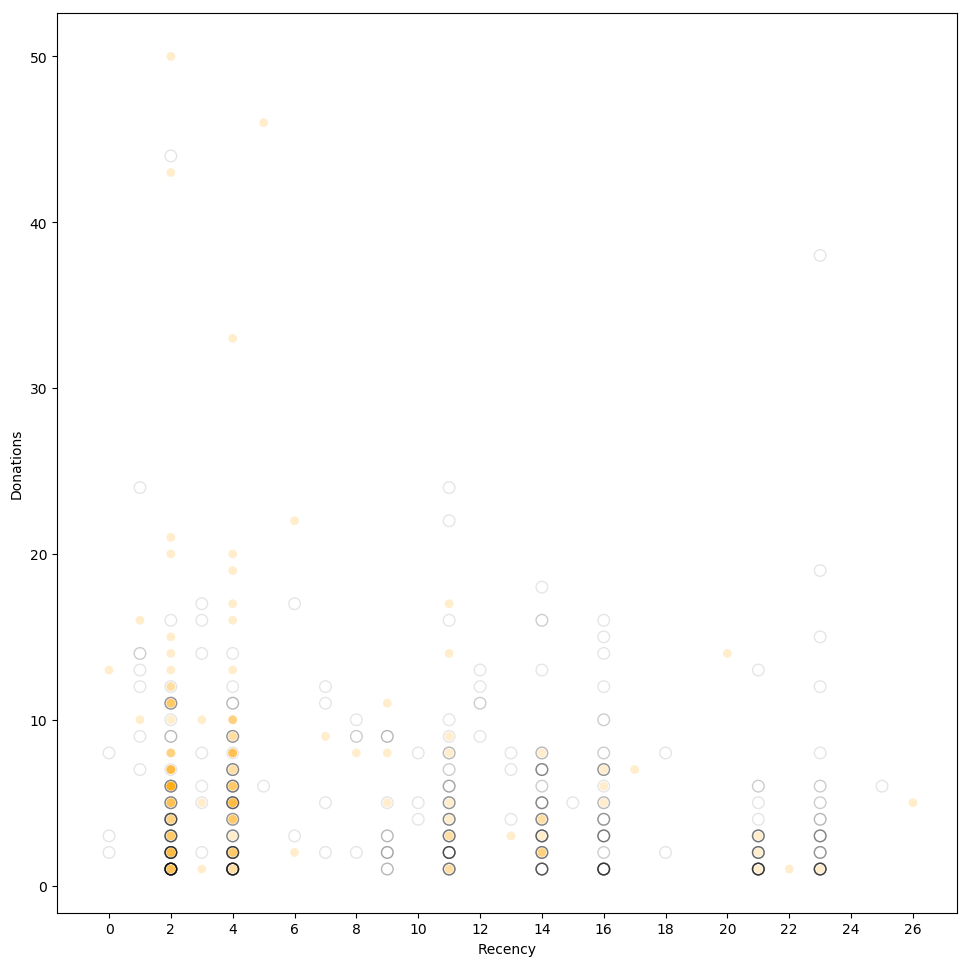

In [13]:
fig = plt.figure(figsize=(9,9),dpi=100)
ax = fig.add_axes([0,0,1,1])
plt.xticks(range(0,80,2))
ax.scatter('Recency','Donations',data=df[(df.Recency < 30) & (df.Target==0)],marker='o',alpha=0.1,s=70,facecolors='none',edgecolors='black')
ax.scatter('Recency','Donations',data=df[(df.Recency < 30) & (df.Target==1)],marker='o',alpha=0.2,s=40,facecolors='orange',edgecolors='none')

plt.xlabel('Recency')
plt.ylabel('Donations')


In [14]:
recencytotals = []
for r in [2,3,4,11,14,21]:
    recencytotals.append([r, df[df.Recency == r].Target.sum(), round(df[df.Recency == r].Target.mean(),2)])
pd.DataFrame(recencytotals,columns=['Recency','March Donors','probability'])

,Recency,March Donors,probability
0,2,56,0.40
1,3,3,0.30
2,4,39,0.34
3,11,10,0.17
4,14,7,0.12
5,21,3,0.08


#### Plot 2

As was mentioned earlier, the Time variable is not in itself very predictive. But the graph below shows that certain regions in the time/donations plane, given certain conditions, have very low numbers of March blood donation. The boundaries of this region could be used to create a feature in the data set.

It is easy to see where boundaries might be drawn in the data, but testing the actual boundaries requires algebra. It makes sense to write code to handle that.

In [15]:
def split_space(X,Y,xlabel,ylabel,data):
    slope = (Y[1]-Y[0])/(X[1]-X[0])
    return (data[ylabel]>slope*(data[xlabel]-X[0])+Y[0],data[ylabel]<=slope*(data[xlabel]-X[0])+Y[0])
    #returns (above,below)

above:  80   0.5194805194805194
below:  7   0.14893617021276595


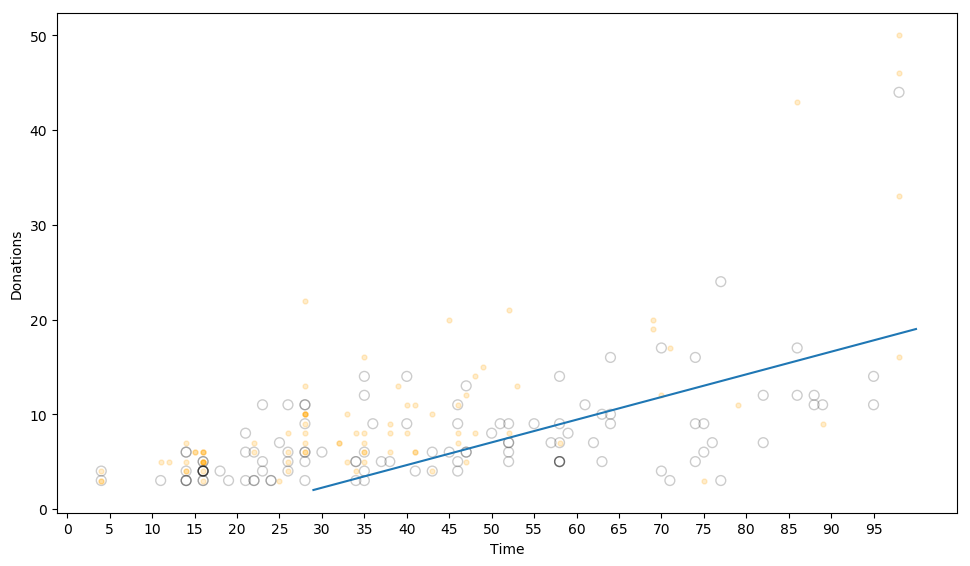

In [161]:
temp = df[(df.Donations>2)&(df.Recency<9)]
fig = plt.figure(figsize=(9,5),dpi=100)
ax = fig.add_axes([0,0,1,1])
ax.scatter('Time','Donations',data=temp[(temp.Target==1)],marker='.',s=50,alpha=0.2,color='orange')
ax.scatter('Time','Donations',data=temp[(temp.Target==0)],alpha=0.2,marker='o',s=50,facecolors='none',edgecolors='black')

x_vals,y_vals = ((29,100),(2,19))
ax.plot(x_vals,y_vals)

x_label,y_label = ('Time','Donations')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xticks(range(0,100,5))

above, below = split_space(x_vals,y_vals,x_label,y_label,temp)
print('above: ',temp[above].Target.sum(),' ',temp[above].Target.mean())
print('below: ',temp[below].Target.sum(),' ',temp[below].Target.mean())

#### Plot 3

Again we are looking for a way to make use of the time variable. In this case we look at the Time-Recency plane.

March Donors: 88    p: 0.42718446601941745


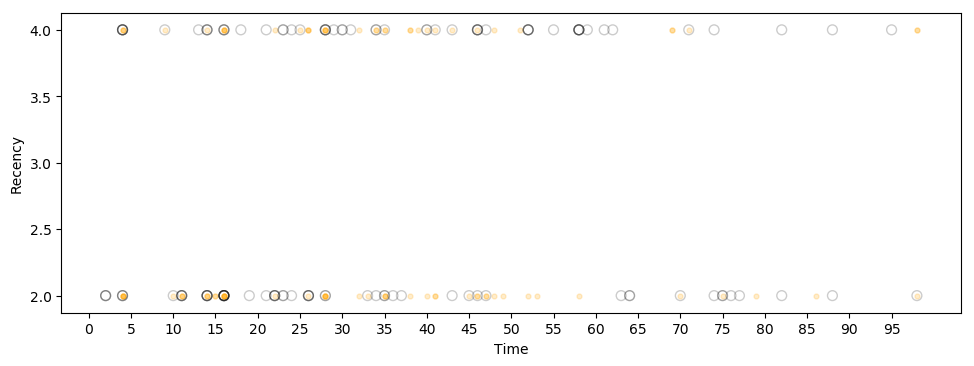

In [17]:
temp = df[(df.Donations>1)&(df.Recency.isin([2,4]))]
fig = plt.figure(figsize=(9,3),dpi=100)
ax = fig.add_axes([0,0,1,1])
plt.xticks(range(0,100,5))
ax.scatter('Time','Recency',data=temp[(temp.Target==1)],marker='.',s=50,alpha=0.2,color='orange')
ax.scatter('Time','Recency',data=temp[(temp.Target==0)],marker='o',s=50,alpha=0.2,facecolors='none',edgecolors='black')

plt.xlabel('Time')
plt.ylabel('Recency')

print('March Donors:',temp.Target.sum(),'   p:',temp.Target.mean())

Data Exploration Summary: We have 6 candidates for feature variables. We also have more insight into the data set. High number of donations and low recency are good indicators. No value of time is a good indicator, but time is useful in conjuction with certain conditions. 

### 3. Feature Creation

Now we'll create 4 features based on the data exploration.

In [100]:
# Feature 1 & 2: Recent multi-donors who fall above (or below) a minimum rate of donations over time. See plot 2

condition = (df.Donations>2)&(df.Recency<9)
x_vals,y_vals = ((29,100),(2,19))
x_label,y_label = ('Time','Donations')

above, below = split_space(x_vals,y_vals,x_label,y_label,df)

df['F1'] = (condition&above).apply(int)
df['F2'] = (condition&below).apply(int)

In [101]:
# Feature 3: Multi-donors who donated 2 or 4 months ago. See plot 3

condition = (df.Donations>1)&df.Recency.isin([2,4])

df['F3'] = condition.apply(int)

In [102]:
# Feature 4: Donations per month since first donation. 

df['F4']=df.Donations/df.Time

In [103]:
df=df[['Recency', 'Donations', 'Time','F1','F2', 'F3','F4','Target']]

In [104]:
df.head(2)

,Recency,Donations,Time,F1,F2,F3,F4,Target
0,2,50,98,1,0,1,0.510204,1
1,0,13,28,1,0,0,0.464286,1


Not all these predictors and features will be used in final model. We want the right balance of simplicity and accuracy.

### 4. Preprocessing

* Split the data into train and test
* Create alternate train and test data sets with the continuous data normalized

In [86]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import Normalizer

In [172]:
X_train,X_test,y_train,y_test = tts(df.drop('Target',axis=1),df.Target,test_size=0.3)

In [173]:
scaler = Normalizer()

X_train_norm = scaler.fit_transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm,columns=X_train.columns,index=X_train.index)

X_test_norm = scaler.fit_transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm,columns=X_test.columns,index=X_test.index)

In [174]:
for F in ['F1','F2','F3','F4']:
    X_train_norm[F]=X_train[F]
    X_test_norm[F]=X_test[F]

In [175]:
X_test_norm.head(2)

,Recency,Donations,Time,F1,F2,F3,F4
469,0.695652,0.173913,0.695652,0,0,0,0.250000
307,0.625817,0.089402,0.774821,0,0,0,0.115385


### 5. Logistic Regression

There are many possible sets of variables to include in the regression. There is also the choice of using original or normalized variables. I tried many combinations. We will look at four:

1. Just Recency and Donations
2. Recency and Donations, both normalized
3. Recency, Donations, F1 and F3
4. Recency normalized, Donations normalized, F1 and F3

The regressions will be compared by f1-score.

In [24]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix,log_loss,f1_score

In [243]:
cols = ['Recency','Donations']

LRmodel = LogisticRegression()
LRmodel.fit(X_train[cols],y_train)

predictions = LRmodel.predict(X_test[cols])
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.81      0.93      0.87       136
          1       0.44      0.19      0.26        37

avg / total       0.73      0.77      0.74       173



In [244]:
LRmodel = LogisticRegression()
LRmodel.fit(X_train_norm[cols],y_train)

predictions = LRmodel.predict(X_test_norm[cols])
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.80      0.99      0.89       136
          1       0.75      0.08      0.15        37

avg / total       0.79      0.80      0.73       173



In [261]:
cols = ['Recency','Donations','F1','F3']

LRmodel = LogisticRegression()
LRmodel.fit(X_train[cols],y_train)

predictions = LRmodel.predict(X_test[cols])
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.84      0.93      0.88       136
          1       0.57      0.32      0.41        37

avg / total       0.78      0.80      0.78       173



Coefficients and odds ratios are printed. According to the model, an increase of 1 month of Recency reduces the March donation odds by about 4%. The opposite is true of donations, an increase of 1 makes the odds about 7% greater. The F1 and F3 variables are binary and as we wuld expect they greatly increase the odds of March donation.


In [212]:
coeff = pd.DataFrame(LRmodel.coef_[0],index=cols,columns=['Coefficient'])
coeff['Odds Ratio'] = np.exp(coeff.Coefficient)
round(coeff,3)

,Coefficient,Odds Ratio
Recency,-0.042,0.959
Donations,0.072,1.074
F1,0.820,2.271
F3,0.485,1.625


In [226]:
LRmodel = LogisticRegression()
LRmodel.fit(X_train_norm[cols],y_train)

predictions = LRmodel.predict(X_test_norm[cols])
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.87      0.91      0.89       136
          1       0.61      0.51      0.56        37

avg / total       0.82      0.83      0.82       173



### 6. Conclusion

#### Summary:
Regression summary: Neither of the first two models is very useful. The point of the exercise is to identify who is likely to donate blood, and neither of those models identifies even one fifth of the target population.

The model with features and normalized variables has the highest f1 score. It also has the highest scores in nearly every other figure of the classification report. This is the only mdel that was able to identify more than half of the March donors (recall 0.51). 

Normalized data does hurt interpretability of the model, and if that is a concern then the third model, with features and non-normalized data could be a good choice.

#### Next Steps:
The logistic regression models would almost certainly be improved with more variables. Biographical information such as age or location data could be useful.

We could also try other machine learning methods such as decision trees or neural networks, although those models may also struggle with the limitted number of predictors.